# Introduction

In this introduction chapter, we will present a first neural network called
the Perceptron.
This model is a neural network made of a single neuron, and we will use it here as a way to introduce key concepts that we will detail later in the course.

In [1]:
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
import matplotlib.pyplot as plt
from notebook_utils import prepare_notebook_graphics
prepare_notebook_graphics()

## A first model: the Perceptron

In the neural network terminology, a neuron is a parametrized function that
takes a vector $\mathbf{x}$ as input and outputs a single value $a$ as follows:

$$
    a = \varphi(\underbrace{\mathbf{w} \mathbf{x} + b}_{o}) ,
$$

where the parameters of the neuron are its weights stored in $\mathbf{w}$
and a bias term $b$, and $\varphi$ is an activation function that is chosen
_a priori_
(we will come back to it in more details later in the course):

```{tikz}
    \node[draw,circle,minimum size=25pt,inner sep=0pt] (x) at (0,0) {$o$};
    \node[minimum size=10pt,inner sep=0pt] (a) at (2, 0) {$\tiny a$};

	\node[minimum size=10pt,inner sep=0pt] (x0) at (-2, 1.5) {$\tiny x_0$};
	\node[minimum size=10pt,inner sep=0pt] (x1) at (-2, 0.75) {$\tiny x_1$};
	\node[minimum size=10pt,inner sep=0pt] (x2) at (-2, 0) {$\tiny x_2$};
	\node[minimum size=10pt,inner sep=0pt] (x3) at (-2, -0.75) {$\tiny x_3$};
	\node[minimum size=10pt,inner sep=0pt] (b) at (-2, -1.5) {$\tiny +1$};

	\draw[->, thick] (x0) to[out=0,in=120] node [midway, sloped, above=-2] {$w_0$} (x);
	\draw[->, thick] (x1) to[out=0,in=150] node [midway, sloped, above=-2] {$w_1$} (x);
	\draw[->, thick] (x2) to[out=0,in=180] node [midway, sloped, above=-2] {$w_2$} (x);
	\draw[->, thick] (x3) to[out=0,in=210] node [midway, sloped, above=-2] {$w_3$} (x);
	\draw[->, thick] (b) to[out=0,in=240] node [midway, sloped, above=-2] {$b$} (x);

	\draw[->, thick] (x) to node [midway,above=-0.1cm] {$\varphi$} (a);
```

A model made of a single neuron is called a Perceptron.

## Optimization

The models presented in this book are aimed at solving prediction problems, in
which the goal is to find "good enough" parameter values for the model at stake
given some observed data.

The problem of finding such parameter values is coined optimization and the deep
learning field makes extensive use of a specific family of optimization
strategies called **gradient descent**.

(sec:boston)=
### Gradient Descent

To make one's mind about gradient descent, let us assume we are given
the following dataset about house prices:

In [2]:
import pandas as pd

boston = pd.read_csv("data/boston.csv")[["RM", "PRICE"]]
boston

,RM,PRICE
0,6.575,24.0
1,6.421,21.6
2,7.185,34.7
3,6.998,33.4
4,7.147,36.2
...,...,...
501,6.593,22.4
502,6.120,20.6
503,6.976,23.9
504,6.794,22.0


In our case, we will try (for a start) to predict the target value of this
dataset, which is the median value of owner-occupied homes in $1000
`"PRICE"`, as a function of the average number of rooms per dwelling `"RM"` :

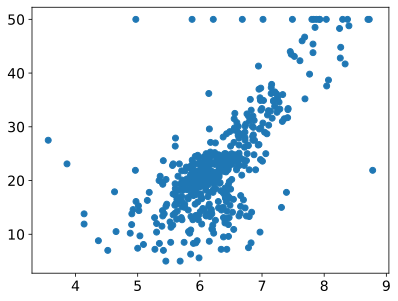

In [3]:
x = boston["RM"]
y = boston["PRICE"]

plt.scatter(x, y);

```{sidebar} A short note on this model

In the Perceptron terminology, this model:
* has no activation function (_i.e._ $\varphi$ is the identity function)
* has no bias (_i.e._ $b$ is forced to be $0$, it is not learnt)
```

Let us assume we have a naive approach in which our prediction model is linear
without intercept, that is, for a given input $x_i$ the predicted output is
computed as:

$$
    \hat{y_i} = w x_i
$$

where $w$ is the only parameter of our model.

Let us further assume that the quantity we aim at minimizing
(our objective, also called loss) is:

$$
    \mathcal{L}(w) = \sum_i \left(\hat{y_i} - y_i\right)^2
$$

where $y_i$ is the ground truth value associated with the $i$-th sample in our
dataset.

Let us have a look at this quantity as a function of $w$:

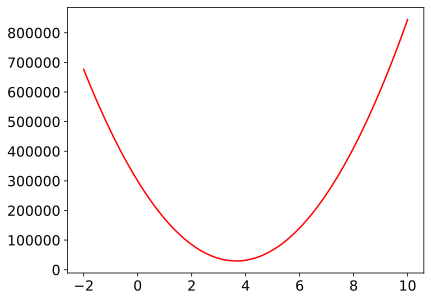

In [4]:
import numpy as np

def loss(w, x, y):
    w = np.array(w)
    return np.sum(
        (w[:, None] * x.to_numpy()[None, :] - y.to_numpy()[None, :]) ** 2,
        axis=1
    )

w = np.linspace(-2, 10, num=100)

plt.plot(w, loss(w, x, y), "r-");

Here, it seems that a value of $w$ around 4 should be a good pick, but this
method (generating lots of values for the parameter and computing the loss for
each value) cannot scale to models that have lots of parameters, so we will
try something else.

Let us suppose we have access, each time we pick a candidate value for $w$,
to both the loss $\mathcal{L}$ and information about how $\mathcal{L}$ varies,
locally.
We could, in this case, compute a new candidate value for $w$ by moving from
the previous candidate value in the direction of steepest descent.
This is the basic idea behind the gradient descent algorithm that, from an
initial candidate $w_0$, iteratively computes new candidates as:

$$
    w_{t+1} = w_t - \rho \left. \frac{\partial \mathcal{L}}{\partial w} \right|_{w=w_t}
$$

where $\rho$ is a hyper-parameter (called the learning rate)
that controls the size of the steps to be done, and
$\left. \frac{\partial \mathcal{L}}{\partial w} \right|_{w=w_t}$ is the
gradient of
$\mathcal{L}$ with respect to $w$, evaluated at $w=w_t$.
As you can see, the direction of steepest descent is the opposite of the
direction pointed by the gradient (and this holds when dealing with vector
parameters too).

This process is repeated until convergence, as illustrated in the following
visualization:

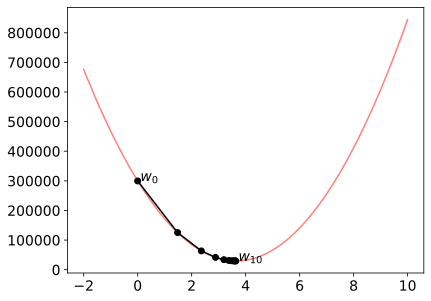

In [5]:
rho = 1e-5

def grad_loss(w_t, x, y):
    return np.sum(
        2 * (w_t * x - y) * x
    )


ww = np.linspace(-2, 10, num=100)
plt.plot(ww, loss(ww, x, y), "r-", alpha=.5);

w = [0.]
for t in range(10):
    w_update = w[t] - rho * grad_loss(w[t], x, y)
    w.append(w_update)

plt.plot(w, loss(w, x, y), "ko-")
plt.text(x=w[0]+.1, y=loss([w[0]], x, y), s="$w_{0}$")
plt.text(x=w[10]+.1, y=loss([w[10]], x, y), s="$w_{10}$");

What would we get if we used a smaller learning rate?

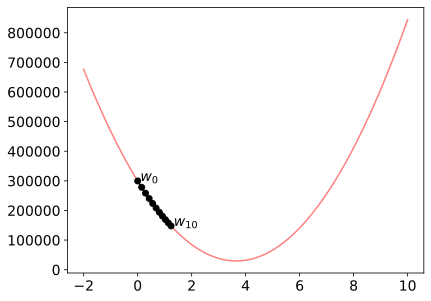

In [6]:
rho = 1e-6

ww = np.linspace(-2, 10, num=100)
plt.plot(ww, loss(ww, x, y), "r-", alpha=.5);

w = [0.]
for t in range(10):
    w_update = w[t] - rho * grad_loss(w[t], x, y)
    w.append(w_update)

plt.plot(w, loss(w, x, y), "ko-")
plt.text(x=w[0]+.1, y=loss([w[0]], x, y), s="$w_{0}$")
plt.text(x=w[10]+.1, y=loss([w[10]], x, y), s="$w_{10}$");

It would definitely take more time to converge.
But, take care, a larger learning rate is not always a good idea:

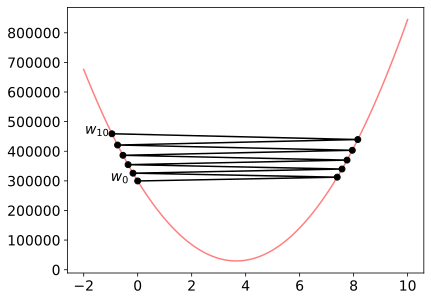

In [7]:
rho = 5e-5

ww = np.linspace(-2, 10, num=100)
plt.plot(ww, loss(ww, x, y), "r-", alpha=.5);

w = [0.]
for t in range(10):
    w_update = w[t] - rho * grad_loss(w[t], x, y)
    w.append(w_update)

plt.plot(w, loss(w, x, y), "ko-")
plt.text(x=w[0]-1., y=loss([w[0]], x, y), s="$w_{0}$")
plt.text(x=w[10]-1., y=loss([w[10]], x, y), s="$w_{10}$");

See how we are slowly diverging because our steps are too large?

## Wrap-up

In this section, we have introduced:
* a very simple model, called the Perceptron: this will be a building block for the more advanced models we will detail later in the course, such as:
    * the [Multi-Layer Perceptron](sec:mlp)
    * [Convolutional architectures](sec:cnn)
    * [Recurrent architectures](sec:rnn)
* the fact that a task comes with a loss function to be minimized (here, we have used the _mean squared error (MSE)_ for our regression task), which will be discussed in [a dedicated chapter](sec:loss);
* the concept of gradient descent to optimize the chosen loss over a model's single parameter, and this will be extended in [our chapter on optimization](sec:sgd).